### Importing neccessary libraries

In [190]:
import torch
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import zipfile as zf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import PIL
from PIL import Image
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
from torchvision.models import resnet18
from tqdm import tqdm
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil
import random
from torchvision import transforms
from PIL import Image
from torch.utils.data import ConcatDataset
from sklearn.metrics import precision_score, recall_score, f1_score

### Importing and Extracting zip file

In [191]:
files = zf.ZipFile("satellite_image_data.zip", 'r')
files.extractall('train')
files.close()

### Visualizing the image of each class

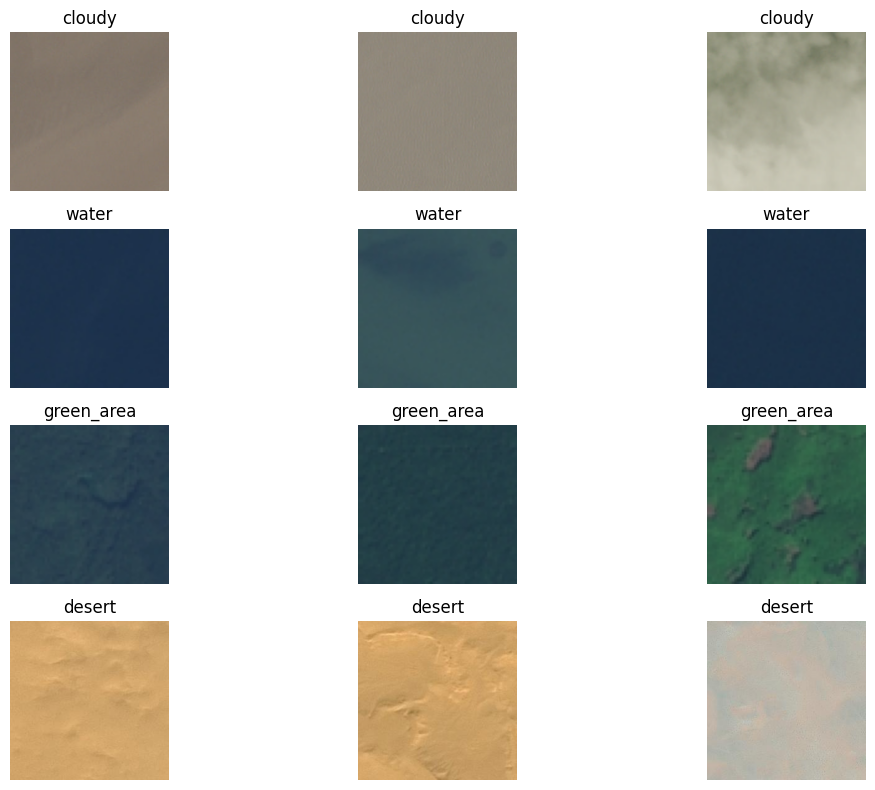

In [192]:
# Define the folders containing images for each class
class_folders = ["cloudy", "water", "green_area", "desert"]

# Number of images to visualize from each class
num_images_per_class = 3

# Set up subplots
fig, axes = plt.subplots(nrows=len(class_folders), ncols=num_images_per_class, figsize=(12, 8))

# Loop through each class folder
for i,class_name in enumerate(class_folders):
    # Get the list of image files in the class folder
    image_files = os.listdir(os.path.join("train/satellite_image_data", class_name))

    # Select a subset of images from the class
    selected_images = image_files[:num_images_per_class]

    for j, img_file in enumerate(selected_images):
        # Load and display the image
        img_path = os.path.join("train/satellite_image_data", class_name, img_file)
        img = mpimg.imread(img_path)

        # Plot the image
        axes[i, j].imshow(img)
        axes[i, j].set_title(class_name)
        axes[i, j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


### Checking the channel mode of the image

In [193]:
image_path='/content/train/satellite_image_data/cloudy/train_10021.jpg'
# Path to the image file
image = PIL.Image.open(image_path)
print(f"Image mode: {image.mode}")


Image mode: CMYK


### Converting the CMYK channel to RBG channel for each image

In [194]:
def convert_to_rgb(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg"):  # all images are JPG format
                file_path = os.path.join(root, file)
                cmyk_image = Image.open(file_path)
                # Convert CMYK to RGB
                rgb_image = cmyk_image.convert("RGB")
                # Save the RGB image, overwrite the original
                rgb_image.save(file_path)

# Define the paths to the train and test folders
train_folder = "train/satellite_image_data"

# Convert images in the train folder to RGB
convert_to_rgb(train_folder)

### Checking the mode of the image after conversion

In [195]:
image_path='/content/train/satellite_image_data/cloudy/train_10224.jpg'
# Path to the image file
image = PIL.Image.open(image_path)
siz= image.size
print(f"Image size: {siz}")
print(f"Image mode: {image.mode}")

Image size: (256, 256)
Image mode: RGB


### Set the random seed

In [196]:
# Set the random seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

### Visualize each class size

Class: green_area, Size: 1500
Class: cloudy, Size: 1500
Class: water, Size: 1500
Class: desert, Size: 1131


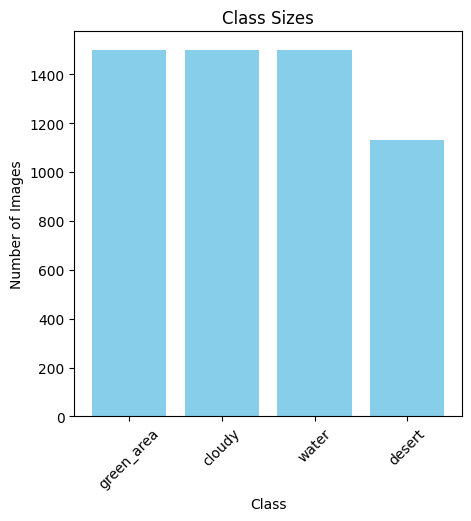

In [197]:
# Path to the parent folder containing the class folders
train_folder = 'train/satellite_image_data'
# Initialize a dictionary to store the size of each class
class_sizes = {}

# Iterate over the class folders
for class_name in os.listdir(train_folder):
    class_folder = os.path.join(train_folder, class_name)
    if os.path.isdir(class_folder):
        # Count the number of files (images) in the class folder
        num_images = len(os.listdir(class_folder))
        class_sizes[class_name] = num_images

# Print the size of each class
for class_name, size in class_sizes.items():
    print(f"Class: {class_name}, Size: {size}")

# Extract class names and sizes
class_names = list(class_sizes.keys())
sizes = list(class_sizes.values())

# Plot the bar chart
plt.figure(figsize=(5, 5))
plt.bar(class_names, sizes, color='skyblue')
plt.title('Class Sizes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


desert class has low number of images as compared to other classes. So augment the images and add to the class to equalize the distribution of sampling within each class.

### Creating transformations

In [198]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define mean and standard deviation for the resnet
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define transformations for training data with augmentation
aug_transform = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 224x224
    transforms.RandomHorizontalFlip(), # flip the image horizontally
    transforms.RandomRotation(10),       # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),               # Convert the image to a tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image with the predefined mean and standard deviation
])

transform = transforms.Compose([ transforms.RandomResizedCrop(224),  # Randomly crop the image and resize to 224x224,
                                transforms.ToTensor(),               # Convert the image to a tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image with the predefined mean and standard deviation
])


Using device: cuda


### Splitting data to train, validation and test data after augmentation

In [199]:
# Path to the parent folder containing the class folders
train_folder = 'train/satellite_image_data'

# Path to the folder containing the desert images
desert_folder = os.path.join(train_folder, 'desert')
print(desert_folder)

# List all the image files in the desert folder
desert_images = [f for f in os.listdir(desert_folder) if os.path.isfile(os.path.join(desert_folder, f))]

# Calculate the number of images currently in the desert folder
current_desert_samples = 1131

# Define the desired number of samples for the desert class
desired_desert_samples = 1500

# Calculate the number of additional samples needed
additional_samples_needed = desired_desert_samples - current_desert_samples

# Augment the dataset by randomly selecting images from the desert folder and applying transformations
for i in range(additional_samples_needed):
    # Randomly select an image from the desert folder
    random_image = random.choice(desert_images)
    image_path = os.path.join(desert_folder, random_image)

    # Open the image
    with Image.open(image_path) as img:
       # Apply transformations
        transformed_image = aug_transform(img)

        # Generate a new filename for the augmented image
        new_filename = f"desert_{i+1000}_{random_image}"
        new_image_path = os.path.join(desert_folder, new_filename)

        # Save the augmented image
        transforms.ToPILImage()(transformed_image).save(new_image_path)

# Print the number of images in the augmented desert folder
augmented_desert_images = os.listdir(desert_folder)
print("Number of augmented images in the desert folder:", len(augmented_desert_images))

# Create the ImageFolder dataset with augmentation for training
train_dataset_org = ImageFolder(train_folder, transform=transform)
aug_train_dataset1 = ImageFolder(train_folder, transform=aug_transform)

# Concatenate the datasets
concatenated_dataset = ConcatDataset([train_dataset_org, aug_train_dataset1])

# Define the percentage of data to be used for validation and testing
validation_ratio = 0.20  # 20% of the data will be used for validation
test_ratio = 0.20        # 20% of the data will be used for testing

# Calculate the number of samples for training, validation, and testing
num_samples = len(concatenated_dataset)
num_validation_samples = int(validation_ratio * num_samples)
num_test_samples = int(test_ratio * num_samples)
num_training_samples = num_samples - num_validation_samples - num_test_samples

# Split the dataset into training, validation, and test sets
train_dataset, validation_dataset, test_dataset = random_split(concatenated_dataset, [num_training_samples, num_validation_samples, num_test_samples])

# Create DataLoaders for training, validation, and test data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Total number of samples:", num_samples)
print("Number of training samples:", num_training_samples)
print("Number of validation samples:", num_validation_samples)
print("Number of test samples:", num_test_samples)

train/satellite_image_data/desert
Number of augmented images in the desert folder: 1500
Total number of samples: 12000
Number of training samples: 7200
Number of validation samples: 2400
Number of test samples: 2400


In [200]:
labels={0:'cloudy',1:'desert',2:'green_area',3:'water'}

In [201]:
from collections import defaultdict

# Initialize a dictionary to store the counts for each class
class_counts = defaultdict(int)

# Count occurrences of each class label in the concatenated dataset
for sample in concatenated_dataset:
    _, label = sample
    class_counts[train_dataset_org.classes[label]] += 1

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

cloudy: 3000
desert: 3000
green_area: 3000
water: 3000


['cloudy', 'desert', 'green_area', 'water'] [3000, 3000, 3000, 3000]


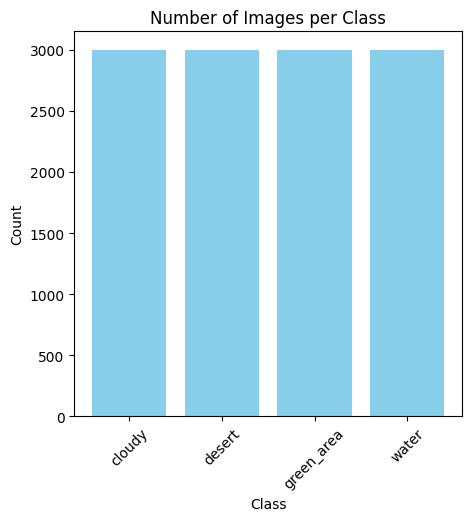

In [202]:
# Import necessary libraries
from collections import defaultdict

# Define class names
class_names = train_dataset_org.classes

# Initialize a dictionary to store the counts for each class
class_counts = defaultdict(int)

# Count occurrences of each class label in the original training dataset
for _, label in concatenated_dataset:
    class_counts[class_names[label]] += 1

# Extract class names and counts
class_names = list(class_counts.keys())
counts = list(class_counts.values())
print(class_names, counts)

# Create bar chart
plt.figure(figsize=(5, 5))
plt.bar(class_names, counts, color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Define the Resnet18 model

In [203]:
# Using pre-trained model(Resnet18)
class RGBResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(RGBResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        # Replace the last fully connected layer with a 4-classes layer
        num_classes = 4
        # Modify the output layer for the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Instantiate the RGBResNet model
model = RGBResNet()
print(model)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RGBResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

### Define Loss function

In [204]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

### Hyperparameter tuning

commented the code and just want to show the result here

In [218]:
"""
# Define lists to store results
best_loss = np.Inf
best_params = {'weight_decay': None, 'lr': None}
num_epochs=10
patience = 2
# Define ranges for weight decay and learning rate
weight_decays = [0.001, 0.01, 0.1]
learning_rates = [0.001, 0.01, 0.1]

# Iterate over weight decays and learning rates
for weight_decay in weight_decays:
    for lr in learning_rates:
        # Define the optimizer with current parameters
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

        # Initialize lists to store losses and accuracies
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        # Initialize variables for statistics
        best_val_loss = np.Inf
        epochs_no_improve = 0

        # Training loop
        for epoch in tqdm(range(num_epochs)):
            running_loss = 0.0
            train_correct = 0
            train_total = 0

            # Iterate over the training data
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            # Validation loop
            val_correct = 0
            val_total = 0
            val_running_loss = 0.0
            with torch.no_grad():
                model.eval()
                for images, labels in validation_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            # Calculate statistics
            train_accuracy = train_correct / train_total
            val_accuracy = val_correct / val_total
            avg_val_loss = val_running_loss / len(validation_loader)
            train_loss = running_loss / len(train_loader)

            # Append statistics to lists
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            val_losses.append(avg_val_loss)
            # Print statistics
            print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {avg_val_loss}")

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve == patience:
                print("Early stopping!")
                break

        # Check if this combination of parameters results in a better validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_params['weight_decay'] = weight_decay
            best_params['lr'] = lr
            print(f"New best parameters: weight_decay={weight_decay}, lr={lr}")

# Print the best parameters
print("Best parameters:")
print(best_params)
"""

 10%|█         | 1/10 [00:37<05:41, 37.92s/it]

Epoch 1, Training Loss: 0.055063992101285195, Training Accuracy: 0.9851388888888889, Validation Accuracy: 0.9841666666666666, Validation Loss: 0.05835082853833835


 20%|██        | 2/10 [01:13<04:53, 36.69s/it]

Epoch 2, Training Loss: 0.05106669375465976, Training Accuracy: 0.9877777777777778, Validation Accuracy: 0.99, Validation Loss: 0.04880971767008305


 30%|███       | 3/10 [01:47<04:06, 35.22s/it]

Epoch 3, Training Loss: 0.05185444303270843, Training Accuracy: 0.9855555555555555, Validation Accuracy: 0.9870833333333333, Validation Loss: 0.046350497975945475


 40%|████      | 4/10 [02:20<03:27, 34.52s/it]

Epoch 4, Training Loss: 0.05093210093884004, Training Accuracy: 0.9865277777777778, Validation Accuracy: 0.9891666666666666, Validation Loss: 0.04536818789939086


 50%|█████     | 5/10 [02:53<02:50, 34.03s/it]

Epoch 5, Training Loss: 0.04892122972549664, Training Accuracy: 0.9870833333333333, Validation Accuracy: 0.98625, Validation Loss: 0.04944652535021305


 50%|█████     | 5/10 [03:27<03:27, 41.49s/it]


Epoch 6, Training Loss: 0.049388349617107044, Training Accuracy: 0.9866666666666667, Validation Accuracy: 0.9883333333333333, Validation Loss: 0.04704284373670817
Early stopping!
New best parameters: weight_decay=0.001, lr=0.001


 10%|█         | 1/10 [00:34<05:06, 34.02s/it]

Epoch 1, Training Loss: 0.05081928611629539, Training Accuracy: 0.9854166666666667, Validation Accuracy: 0.9879166666666667, Validation Loss: 0.04348274271935224


 20%|██        | 2/10 [01:08<04:32, 34.01s/it]

Epoch 2, Training Loss: 0.05619154329101245, Training Accuracy: 0.9827777777777778, Validation Accuracy: 0.9829166666666667, Validation Loss: 0.05336770959198475


 20%|██        | 2/10 [01:42<06:50, 51.28s/it]


Epoch 3, Training Loss: 0.046867177680962616, Training Accuracy: 0.9855555555555555, Validation Accuracy: 0.9833333333333333, Validation Loss: 0.04850260179800292
Early stopping!


 10%|█         | 1/10 [00:33<05:02, 33.64s/it]

Epoch 1, Training Loss: 0.8545764028987529, Training Accuracy: 0.9234722222222222, Validation Accuracy: 0.9695833333333334, Validation Loss: 0.24963787882671776


 20%|██        | 2/10 [01:07<04:29, 33.73s/it]

Epoch 2, Training Loss: 0.2858787382276597, Training Accuracy: 0.9640277777777778, Validation Accuracy: 0.86625, Validation Loss: 1.1791742265302068


 30%|███       | 3/10 [01:41<03:56, 33.79s/it]

Epoch 3, Training Loss: 0.2535206749748489, Training Accuracy: 0.9652777777777778, Validation Accuracy: 0.9716666666666667, Validation Loss: 0.16518067655455562


 40%|████      | 4/10 [02:14<03:22, 33.75s/it]

Epoch 4, Training Loss: 0.3562077434729414, Training Accuracy: 0.9598611111111112, Validation Accuracy: 0.9679166666666666, Validation Loss: 0.27079486121726093


 40%|████      | 4/10 [02:47<04:11, 41.98s/it]


Epoch 5, Training Loss: 0.30226970909978707, Training Accuracy: 0.96375, Validation Accuracy: 0.9470833333333334, Validation Loss: 0.44521209323526156
Early stopping!


 10%|█         | 1/10 [00:33<05:03, 33.76s/it]

Epoch 1, Training Loss: 0.15427273277963152, Training Accuracy: 0.9775, Validation Accuracy: 0.985, Validation Loss: 0.07968385058322268


 20%|██        | 2/10 [01:07<04:31, 33.89s/it]

Epoch 2, Training Loss: 0.10519255649058468, Training Accuracy: 0.9838888888888889, Validation Accuracy: 0.9845833333333334, Validation Loss: 0.061390310910903356


 30%|███       | 3/10 [01:41<03:58, 34.05s/it]

Epoch 3, Training Loss: 0.10974477630374295, Training Accuracy: 0.9829166666666667, Validation Accuracy: 0.98375, Validation Loss: 0.0868097838139136


 30%|███       | 3/10 [02:15<05:16, 45.28s/it]


Epoch 4, Training Loss: 0.0821268968180826, Training Accuracy: 0.9840277777777777, Validation Accuracy: 0.9829166666666667, Validation Loss: 0.10891218224722982
Early stopping!


 10%|█         | 1/10 [00:33<05:00, 33.40s/it]

Epoch 1, Training Loss: 0.09484525382309439, Training Accuracy: 0.9827777777777778, Validation Accuracy: 0.9879166666666667, Validation Loss: 0.05461342507883273


 20%|██        | 2/10 [01:07<04:28, 33.57s/it]

Epoch 2, Training Loss: 0.06483127851135338, Training Accuracy: 0.9819444444444444, Validation Accuracy: 0.9820833333333333, Validation Loss: 0.06963952572931399


 30%|███       | 3/10 [01:40<03:55, 33.67s/it]

Epoch 3, Training Loss: 0.05647657081542598, Training Accuracy: 0.9838888888888889, Validation Accuracy: 0.9933333333333333, Validation Loss: 0.021521454081957925


 40%|████      | 4/10 [02:14<03:21, 33.63s/it]

Epoch 4, Training Loss: 0.04269455085110773, Training Accuracy: 0.9861111111111112, Validation Accuracy: 0.9870833333333333, Validation Loss: 0.038200888087352114


 40%|████      | 4/10 [02:47<04:11, 41.84s/it]


Epoch 5, Training Loss: 0.032020327938177315, Training Accuracy: 0.9875, Validation Accuracy: 0.9883333333333333, Validation Loss: 0.03483685711010669
Early stopping!
New best parameters: weight_decay=0.01, lr=0.01


 10%|█         | 1/10 [00:33<05:03, 33.72s/it]

Epoch 1, Training Loss: 0.6237452470513624, Training Accuracy: 0.9119444444444444, Validation Accuracy: 0.93625, Validation Loss: 0.3162161811317007


 20%|██        | 2/10 [01:07<04:31, 33.96s/it]

Epoch 2, Training Loss: 0.9271257474039319, Training Accuracy: 0.8977777777777778, Validation Accuracy: 0.93625, Validation Loss: 0.7435552367571897


 20%|██        | 2/10 [01:42<06:49, 51.19s/it]


Epoch 3, Training Loss: 0.7689923679754429, Training Accuracy: 0.9095833333333333, Validation Accuracy: 0.9358333333333333, Validation Loss: 0.43905482961340264
Early stopping!


 10%|█         | 1/10 [00:33<05:04, 33.85s/it]

Epoch 1, Training Loss: 0.2098982970784295, Training Accuracy: 0.9615277777777778, Validation Accuracy: 0.9654166666666667, Validation Loss: 0.22895081691482724


 20%|██        | 2/10 [01:07<04:30, 33.87s/it]

Epoch 2, Training Loss: 0.14266700069631852, Training Accuracy: 0.9672222222222222, Validation Accuracy: 0.975, Validation Loss: 0.11832675991114229


 30%|███       | 3/10 [01:41<03:57, 33.98s/it]

Epoch 3, Training Loss: 0.10243498939089477, Training Accuracy: 0.9736111111111111, Validation Accuracy: 0.9770833333333333, Validation Loss: 0.09051617579806286


 40%|████      | 4/10 [02:15<03:23, 33.95s/it]

Epoch 4, Training Loss: 0.09375043853114928, Training Accuracy: 0.9719444444444445, Validation Accuracy: 0.9766666666666667, Validation Loss: 0.08668172771732012


 50%|█████     | 5/10 [02:49<02:49, 33.87s/it]

Epoch 5, Training Loss: 0.08581852494169855, Training Accuracy: 0.9734722222222222, Validation Accuracy: 0.97625, Validation Loss: 0.07593383472412825


 60%|██████    | 6/10 [03:22<02:14, 33.73s/it]

Epoch 6, Training Loss: 0.06950096444537242, Training Accuracy: 0.9770833333333333, Validation Accuracy: 0.9808333333333333, Validation Loss: 0.06965709446618955


 70%|███████   | 7/10 [03:56<01:40, 33.56s/it]

Epoch 7, Training Loss: 0.07886440376440684, Training Accuracy: 0.9765277777777778, Validation Accuracy: 0.9804166666666667, Validation Loss: 0.08322880049546559


 70%|███████   | 7/10 [04:29<01:55, 38.51s/it]


Epoch 8, Training Loss: 0.09178898310495748, Training Accuracy: 0.9773611111111111, Validation Accuracy: 0.98125, Validation Loss: 0.09421137471993764
Early stopping!


 10%|█         | 1/10 [00:34<05:07, 34.22s/it]

Epoch 1, Training Loss: 0.13564962392052016, Training Accuracy: 0.9676388888888889, Validation Accuracy: 0.91125, Validation Loss: 0.23482566754023235


 20%|██        | 2/10 [01:07<04:29, 33.67s/it]

Epoch 2, Training Loss: 0.15511291129721536, Training Accuracy: 0.9573611111111111, Validation Accuracy: 0.9770833333333333, Validation Loss: 0.13123109847307204


 30%|███       | 3/10 [01:40<03:54, 33.54s/it]

Epoch 3, Training Loss: 0.15542591725786528, Training Accuracy: 0.9597222222222223, Validation Accuracy: 0.9529166666666666, Validation Loss: 0.17118845413128536


 40%|████      | 4/10 [02:14<03:20, 33.49s/it]

Epoch 4, Training Loss: 0.1553047544757525, Training Accuracy: 0.9559722222222222, Validation Accuracy: 0.97125, Validation Loss: 0.1290425262848536


 50%|█████     | 5/10 [02:47<02:47, 33.49s/it]

Epoch 5, Training Loss: 0.14942205647627513, Training Accuracy: 0.9629166666666666, Validation Accuracy: 0.9741666666666666, Validation Loss: 0.1290489097436269


 50%|█████     | 5/10 [03:21<03:21, 40.29s/it]


Epoch 6, Training Loss: 0.1514324357940091, Training Accuracy: 0.9627777777777777, Validation Accuracy: 0.96, Validation Loss: 0.15147401223580043
Early stopping!


 10%|█         | 1/10 [00:33<04:58, 33.21s/it]

Epoch 1, Training Loss: 2.011049576898416, Training Accuracy: 0.7572222222222222, Validation Accuracy: 0.84, Validation Loss: 0.8097423902899027


 20%|██        | 2/10 [01:06<04:26, 33.35s/it]

Epoch 2, Training Loss: 2.332147999865313, Training Accuracy: 0.7456944444444444, Validation Accuracy: 0.64875, Validation Loss: 9.059734052022298


 30%|███       | 3/10 [01:40<03:55, 33.62s/it]

Epoch 3, Training Loss: 1.8366526811156008, Training Accuracy: 0.7727777777777778, Validation Accuracy: 0.8275, Validation Loss: 0.7085271341105303


 40%|████      | 4/10 [02:14<03:22, 33.82s/it]

Epoch 4, Training Loss: 1.416794232800603, Training Accuracy: 0.7798611111111111, Validation Accuracy: 0.7075, Validation Loss: 2.7039300243059796


 50%|█████     | 5/10 [02:47<02:47, 33.52s/it]

Epoch 5, Training Loss: 1.5709832005451123, Training Accuracy: 0.7751388888888889, Validation Accuracy: 0.8654166666666666, Validation Loss: 0.597191319912672


 60%|██████    | 6/10 [03:21<02:14, 33.50s/it]

Epoch 6, Training Loss: 1.7042100029852656, Training Accuracy: 0.7695833333333333, Validation Accuracy: 0.7291666666666666, Validation Loss: 1.5384174315134684


 60%|██████    | 6/10 [03:54<02:36, 39.14s/it]

Epoch 7, Training Loss: 2.412110142947899, Training Accuracy: 0.7473611111111111, Validation Accuracy: 0.8466666666666667, Validation Loss: 0.8904073597987493
Early stopping!
Best parameters:
{'weight_decay': 0.01, 'lr': 0.01}


### Define the optimizer

In [206]:
# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

### Train the model

In [207]:
# Create a list for visuaization
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define the number of epochs to wait before early stopping
patience = 2

# Initialize variables to track best validation loss and number of epochs without improvement
best_val_loss = np.Inf
epochs_no_improve = 0
num_epochs=10
for epoch in tqdm(range(num_epochs)):
    # Set the model to training mode
    #model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    train_loss=0.
    # Iterate over the training data
    for images, labels in train_loader:
        # Move batch to GPU
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        # Update total number of samples
        train_total += labels.size(0)

        # Update number of correct predictions
        train_correct += (predicted == labels).sum().item()

    # Initialize variables to compute accuracy and validation loss
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    # Iterate over the validation data
    with torch.no_grad():
    # Set the model to evaluation mode
      model.eval()
      # Iterate over the validation data
      for images, labels in validation_loader:
          # Move batch to GPU
          images, labels = images.to(device), labels.to(device)

          # Forward pass
          outputs = model(images)

          # Compute the validation loss
          loss = criterion(outputs, labels)
          val_running_loss += loss.item()

          # Get predictions
          _, predicted = torch.max(outputs.data, 1)

          # Update total number of samples
          val_total += labels.size(0)

          # Update number of correct predictions
          val_correct += (predicted == labels).sum().item()

    # Calculate accuracy
    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total
    avg_val_loss = val_running_loss / len(validation_loader)
    train_loss=running_loss / len(train_loader)
    # Append statistics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    val_losses.append(avg_val_loss)

    # Print statistics
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Validation Loss: {avg_val_loss}")

    # Check if validation loss has improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Check if early stopping criteria met
    if epochs_no_improve == patience:
        print("Early stopping!")
        break


 10%|█         | 1/10 [00:34<05:12, 34.69s/it]

Epoch 1, Training Loss: 0.27463817697018383, Training Accuracy: 0.8927777777777778, Validation Accuracy: 0.9654166666666667, Validation Loss: 0.10700352431585392


 20%|██        | 2/10 [01:09<04:39, 34.96s/it]

Epoch 2, Training Loss: 0.0856522865841786, Training Accuracy: 0.9718055555555556, Validation Accuracy: 0.9658333333333333, Validation Loss: 0.11185147687792778


 30%|███       | 3/10 [01:44<04:02, 34.63s/it]

Epoch 3, Training Loss: 0.07858560585313373, Training Accuracy: 0.9754166666666667, Validation Accuracy: 0.98625, Validation Loss: 0.0540650221084555


 40%|████      | 4/10 [02:17<03:25, 34.23s/it]

Epoch 4, Training Loss: 0.07366986697332727, Training Accuracy: 0.9758333333333333, Validation Accuracy: 0.9808333333333333, Validation Loss: 0.05910984647770723


 40%|████      | 4/10 [02:51<04:17, 42.84s/it]

Epoch 5, Training Loss: 0.06889394031216702, Training Accuracy: 0.9815277777777778, Validation Accuracy: 0.9829166666666667, Validation Loss: 0.06296364814043046
Early stopping!


### Evaluation of the model

In [208]:
# Test the model on test data and get confusion matrix
model.eval()
y_true = []
y_pred = []
# Total number of correct predictions
correct_predictions = 0
with torch.no_grad():
    # Iterate over test data
  for data in test_loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # Forward pass
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)

      # Append true and predicted labels
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())
      # Update the number of correct predictions
      correct_predictions += (predicted == labels).sum().item()

# Calculate the total number of samples
total_samples = len(y_true)

# Calculate the accuracy
accuracy = correct_predictions / total_samples
print('Accuracy of the test data: {:.2f}%'.format(100 * accuracy))

Accuracy of the test data: 97.71%


In [209]:
# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9773726833887795
Recall: 0.9770833333333333
F1 Score: 0.9770709468405194


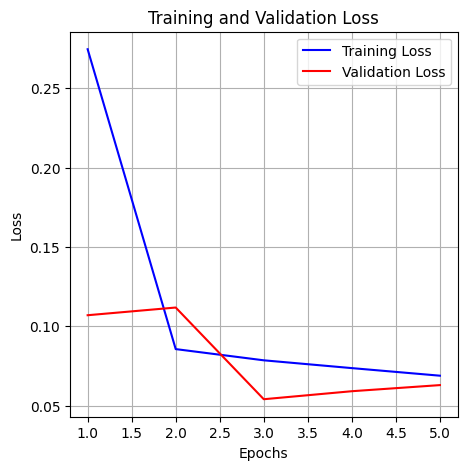

In [210]:
# Plot loss
plt.figure(figsize=(5, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, 'b', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

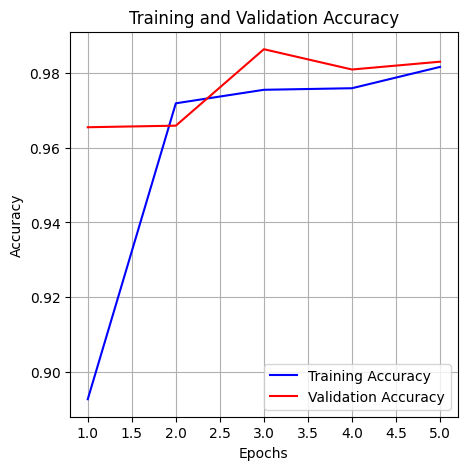

In [211]:
# Plot accuracy
plt.figure(figsize=(5, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Created confusion matrix

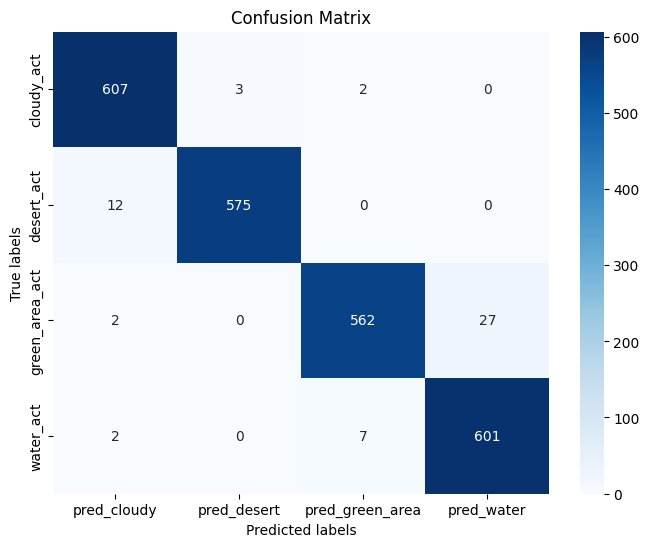

In [212]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["pred_cloudy", "pred_desert", "pred_green_area", "pred_water"], yticklabels=['cloudy_act','desert_act','green_area_act','water_act'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Test the model

https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.jpl.nasa.gov%2Fnews%2Fnasa-satellite-finds-earths-clouds-are-getting-lower&psig=AOvVaw0Tsk9XKDbX4TqBnM22s9XE&ust=1712204424183000&source=images&cd=vfe&opi=89978449&ved=0CBIQjRxqFwoTCLCxndmYpYUDFQAAAAAdAAAAABAE

In [214]:
labels={0:'cloudy',1:'desert',2:'green_area',3:'water'}

tensor([0], device='cuda:0')
0
Predicted label: cloudy


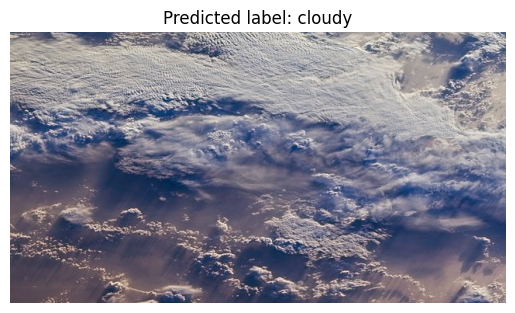

In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Assuming 'model' is your PyTorch model object

# Load and preprocess the unseen image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image = Image.open('cloudy-1.jpg')

# Resize the image
resized_image = image.resize((224, 224))  # Resize to match the input size expected by your model

# Transform the image
input_image = transform(resized_image).unsqueeze(0)  # Add batch dimension
# Move the input tensor to the same device as the model
input_image = input_image.to(device)
# Pass the input image through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_image)

# Get the predicted label
predictions = torch.argmax(output, dim=1)
print(predictions)
predicted_label = predictions.item()
print(predicted_label)

print("Predicted label:", labels[predicted_label])
# Visualize the image
plt.imshow(image)
plt.axis('off')
plt.title('Predicted label: {}'.format(labels[predicted_label]))
plt.show()


https://fineartamerica.com/featured/satellite-view-of-desert-area-panoramic-images.html

tensor([1], device='cuda:0')
1
Predicted label: desert


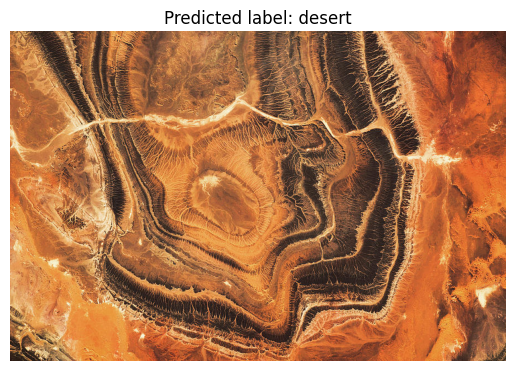

In [215]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Assuming 'model' is your PyTorch model object

# Load and preprocess the unseen image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image = Image.open('desert-1.jpg')

# Resize the image
resized_image = image.resize((224, 224))  # Resize to match the input size expected by your model

# Transform the image
input_image = transform(resized_image).unsqueeze(0)  # Add batch dimension
# Move the input tensor to the same device as the model
input_image = input_image.to(device)
# Pass the input image through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_image)

# Get the predicted label
predictions = torch.argmax(output, dim=1)
print(predictions)
predicted_label = predictions.item()
print(predicted_label)

print("Predicted label:", labels[predicted_label])
# Visualize the image
plt.imshow(image)
plt.axis('off')
plt.title('Predicted label: {}'.format(labels[predicted_label]))
plt.show()


https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.nationalgeographic.com%2Fscience%2Farticle%2F130619-vegetation-green-earth-science-technology-environment&psig=AOvVaw2ctqAyodZip3Uwhek2Eyf-&ust=1712247175819000&source=images&cd=vfe&opi=89978449&ved=0CBIQjRxqFwoTCMi50Pm3poUDFQAAAAAdAAAAABAE

Predicted label: desert


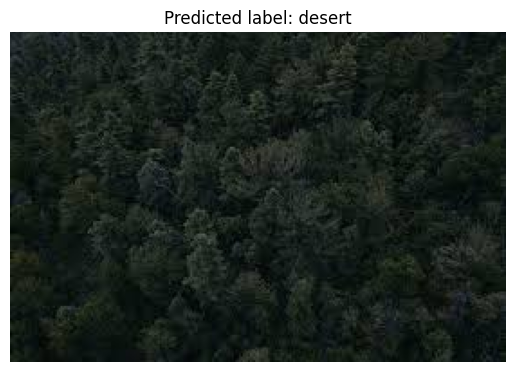

In [185]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Assuming 'model' is your PyTorch model object

# Load and preprocess the unseen image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image = Image.open('green_area1.jpg')

# Resize the image
resized_image = image.resize((224, 224))  # Resize to match the input size expected by your model

# Transform the image
input_image = transform(resized_image).unsqueeze(0)  # Add batch dimension
# Move the input tensor to the same device as the model
input_image = input_image.to(device)
# Pass the input image through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_image)

# Get the predicted label
predictions = torch.argmax(output, dim=1)
predicted_label = predictions.item()

print("Predicted label:", labels[predicted_label])
# Visualize the image
plt.imshow(image)
plt.axis('off')
plt.title('Predicted label: {}'.format(labels[predicted_label]))
plt.show()


https://www.google.com/imgres?imgurl=https%3A%2F%2Fcdn.openart.ai%2Fstable_diffusion%2F08d598d672097d65d7ff1fa9e9455e2114d5560d_2000x2000.webp&tbnid=EeovhH4hdCU1aM&vet=10CBAQxiAoA2oXChMI6MmstJ6lhQMVAAAAAB0AAAAAEA8..i&imgrefurl=https%3A%2F%2Fopenart.ai%2Fdiscovery%2Fsd-1007375181817331813&docid=XdRvjT6530bSpM&w=1024&h=1024&itg=1&q=ocean%20satellite%20view&hl=en&ved=0CBAQxiAoA2oXChMI6MmstJ6lhQMVAAAAAB0AAAAAEA8

Predicted label: water


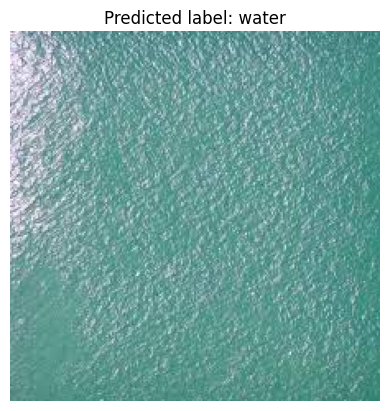

In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Assuming 'model' is your PyTorch model object

# Load and preprocess the unseen image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image = Image.open('water3.png')

# Resize the image
resized_image = image.resize((224, 224))  # Resize to match the input size expected by your model

# Transform the image
input_image = transform(resized_image).unsqueeze(0)  # Add batch dimension
# Move the input tensor to the same device as the model
input_image = input_image.to(device)
# Pass the input image through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_image)

# Get the predicted label
predictions = torch.argmax(output, dim=1)
predicted_label = predictions.item()

print("Predicted label:", labels[predicted_label])
# Visualize the image
plt.imshow(image)
plt.axis('off')
plt.title('Predicted label: {}'.format(labels[predicted_label]))
plt.show()
